# Import tools

In [204]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from collections import defaultdict

from scipy.stats import normaltest

import warnings
warnings.filterwarnings("ignore")

import json
import re

sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)


In [205]:
df = pd.read_csv('data/last_version.csv')

# Preprocess

In [525]:
def preprocess_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    
    def _count_shape(df):
        print(f'shape: {df.shape[0]}\nunique rows by PK==id: {df["id"].nunique()}')
        
    def _filter_raw_rows(df: pd.DataFrame) -> pd.DataFrame:
        df['id_new'] = df['id'].astype(str)
        df['indicator'] = df['id_new'].str.isdigit()
        df = df[df['indicator'] == True]
        return df.drop(['id_new', 'indicator'], axis=1)
    
    _count_shape(df)
#     df = _filter_raw_rows(df)
    _count_shape(df)
    
    df.index = df['id']
    df.drop(columns=['id'], inplace=True)
    
    return df



def preproces(df):
    df.index = df['_id']
    df.drop(columns='_id', inplace=True)

    df['author_name'] = df['authors'].apply(get_author_name)
    df['venue_name'] = df['venue'].apply(get_venue_name)

    df = df.explode('author_name')
    df = df.explode('venue_name')

    df.drop(columns=['authors', 'venue'], inplace=True)
    return df

In [526]:
# тут должно было все работать, но у нас v13...

# df = preproces(df)

## Nans

In [533]:
def get_nan(df):
    def _df_style(v):
        return "font-weight: bold; color: red;" if v > 25 else None
    
    sns.heatmap(df.isna());
    plt.title('Visualization of NAs in dataset (white - missing values)\n');
    
    temp = {'col': [], 'perc_nan': []}
    for col in df.columns:
        perc_nan = df[col].isna().sum() / df.shape[0]  * 100
        temp['col'] += [col]
        temp['perc_nan'] += [perc_nan]

    temp = pd.DataFrame(temp)
    temp.set_index(['col'], inplace=True)
    subset = temp[temp['perc_nan'] > 50]
    summary = temp.style.applymap(_df_style)
    display(summary)
    return temp

,perc_nan
col,
Unnamed: 0,0.000000
_id,0.000000
title,0.007655
authors,0.076130
venue,0.058801
year,0.000841
keywords,24.649169
fos,5.276215
references,22.225615


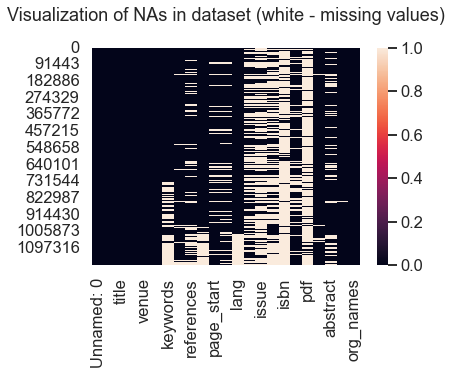

In [534]:
nans = get_nan(df)

In [538]:
nans = nans.reset_index()
nans = nans.iloc[1:, :]
nans.columns = ['Column Name', 'Percentage of Nans']

In [596]:
fig = px.bar(data_frame=nans, x='Column Name', y='Percentage of Nans', color='Percentage of Nans', 
       color_continuous_scale=px.colors.sequential.Blues,
       title='Density of Nans in Percentage (%)')

fig.update_layout(title_x=0.5)

In [597]:
def filter_useless(df: pd.DataFrame, del_cols=['pdf', 'isbn', 'issn', 'issue', 'doi', 
                                               'url', 'Unnamed: 0', '_id', 'authors']):
    df = df.drop(columns=del_cols, axis=1)
    return df

In [598]:
df = filter_useless(df)

In [676]:
df.head(1)

,title,venue,year,keywords,fos,references,n_citation,page_start,page_end,lang,volume,abstract,auther_name,org_names
0,A solution to the problem of touching and brok...,"{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"['handwriting recognition', 'prototypes', 'ima...","['Intelligent character recognition', 'Pattern...","['53e99cf5b7602d97025ace63', '557e8a7a6fee0fe9...",17.0,602,605,en,NaN,NaN,Theo Pavlidis,[]


,perc_nan
col,
title,0.007655
venue,0.058801
year,0.000841
keywords,24.649169
fos,5.276215
references,22.225615
n_citation,12.887487
page_start,12.866036
page_end,16.076803


,perc_nan
col,
title,0.007655
venue,0.058801
year,0.000841
keywords,24.649169
fos,5.276215
references,22.225615
n_citation,12.887487
page_start,12.866036
page_end,16.076803


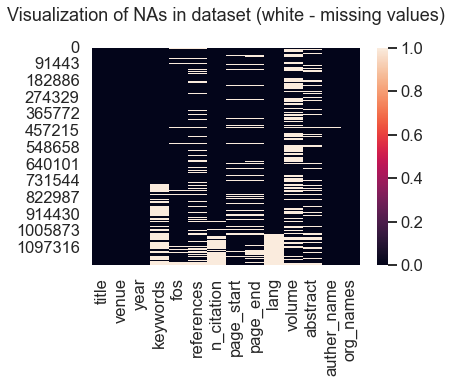

In [677]:
get_nan(df)

In [681]:
df['lang'].value_counts()

en    1017199
zh         87
Name: lang, dtype: int64

## col: volume 

In [652]:
volume = df[((~df['volume'].isna()) & (df['volume'].str.isnumeric()))]['volume']

In [654]:
volume.shape

(550186,)

In [655]:
df.shape

(1188750, 14)

In [669]:
volume = volume.astype(float)
volume = volume.sort_values()
volume = volume[volume < 600]

In [674]:
volume.shape[0] / df.shape[0] * 100

40.92231335436382

# EDA

## stats about authors

In [267]:
df.head()

,Unnamed: 0,_id,title,authors,venue,year,keywords,fos,references,n_citation,...,volume,issue,issn,isbn,doi,pdf,url,abstract,auther_name,org_names
0,0,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"['handwriting recognition', 'prototypes', 'ima...","['Intelligent character recognition', 'Pattern...","['53e99cf5b7602d97025ace63', '557e8a7a6fee0fe9...",17.0,...,NaN,NaN,NaN,NaN,10.1109/ICDAR.1993.395663,NaN,['http://dx.doi.org/10.1109/ICDAR.1993.395663'],NaN,Theo Pavlidis,[]
1,0,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"['handwriting recognition', 'prototypes', 'ima...","['Intelligent character recognition', 'Pattern...","['53e99cf5b7602d97025ace63', '557e8a7a6fee0fe9...",17.0,...,NaN,NaN,NaN,NaN,10.1109/ICDAR.1993.395663,NaN,['http://dx.doi.org/10.1109/ICDAR.1993.395663'],NaN,Jairo Rocha,[]
2,1,53e99784b7602d9701f3e161,360°,"[{'_id': '53f46946dabfaec09f24b4ed', 'name': '...","{'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...",2009.0,"['global high technology', 'daily short-distan...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.1145/1665137.1665166,NaN,NaN,360° represents the concerns that are addresse...,Miguel Palma,['Miguel Palma Studio']
3,2,53e99784b7602d9701f3f992,Firewalls.,"[{'_id': '53f453aedabfaeb22f4f637d', 'name': '...",{'raw': 'Encyclopedia of Cryptography and Secu...,2011.0,[],NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,['http://dx.doi.org/10.1007/978-1-4419-5906-5_...,NaN,Ehab Al-Shaer,[]
4,3,53e99784b7602d9701f3f62a,Flubber,"[{'_id': '53f4309ddabfaeb1a7bb434b', 'name': '...","{'_id': '5736ae3ad39c4f40a797600a', 'raw': 'SI...",1998.0,[],NaN,NaN,0.0,...,NaN,NaN,NaN,1-58113-045-7,10.1145/281388.281867,NaN,"['http://dx.doi.org/10.1145/281388.281867', 'h...",NaN,Vicki Dobbs Beck,[]


In [309]:
stat_auth = df[['title', 'auther_name']]
stat_auth['count'] = 1
stat_auth = stat_auth.groupby('title').count().reset_index()
stat_auth['count'] = np.where(stat_auth['count'] > 10, 11, stat_auth['count'])
stat_auth['val'] = 1
stat_auth = stat_auth.groupby('count').agg({'val': 'count'}).reset_index()
stat_auth.columns = ['Number of Authors', 'Count']
stat_auth

,Number of Authors,Count
0,1,63807
1,2,100978
2,3,94766
3,4,63163
4,5,31392
5,6,15624
6,7,6918
7,8,3411
8,9,1847
9,10,1114


In [313]:
stat_auth[stat_auth['Number of Authors'] < 0]

,Number of Authors,Count


In [364]:
plt.rcParams['figure.figsize'] = (12, 8)


Text(0.5, 1.0, 'Distribution of Authors per Paper')

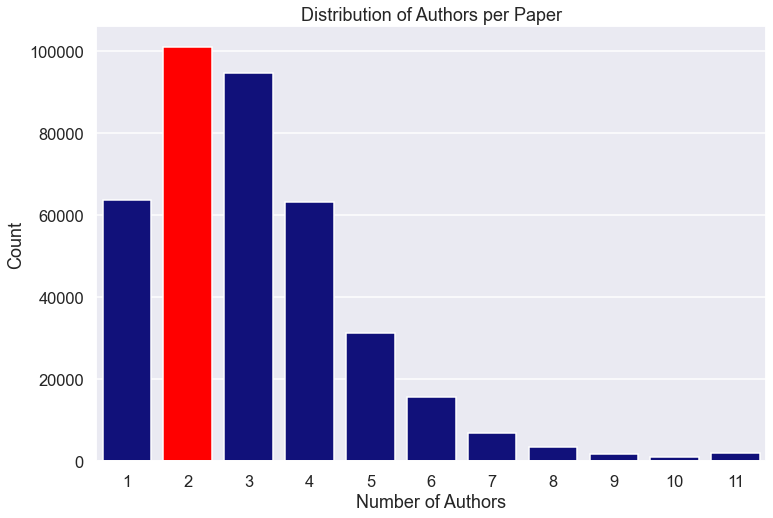

In [365]:
bar = sns.barplot(x='Number of Authors', y='Count', data=stat_auth, 
                  color='#00008B')
patch_h = [patch.get_height() for patch in bar.patches]
idx_tallest = np.argmax(patch_h)   
bar.patches[idx_tallest].set_facecolor('#FF0000')
bar.set_title('Distribution of Authors per Paper')

## long full data

In [2]:
df_fos = pd.read_csv("data/dblpv13_fos.csv")
df_lang = pd.read_csv("data/dblpv13_lang.csv")
df_n_citation = pd.read_csv("data/dblpv13_n_citation.csv")
df_year = pd.read_csv("data/dblpv13_year.csv")

df_total = pd.concat([df_fos, df_lang, df_n_citation, df_year], axis=1, ignore_index=False)

In [3]:
df_total.head()

,fos,lang,n_citation,year
0,NaN,en,0.0,2011.0
1,"['Agronomy', 'Moisture', 'Hydrology', 'Environ...",en,0.0,2011.0
2,"['Intelligent character recognition', 'Pattern...",en,17.0,1993.0
3,"['Delay calculation', 'Timing failure', 'Monte...",en,28.0,2005.0
4,NaN,en,NaN,2009.0


### lang 

In [43]:
nans = df_total.lang.value_counts(dropna=False)
nans = pd.DataFrame(nans)
nans = nans.reset_index()
nans.iloc[:, 0][1] = 'Nothing'
nans.index = nans.index.astype(str)

In [238]:
# px.bar(data_frame=nans, x='idndex', y='lang')

### dist of n_citi... and n_of_papers per years

In [384]:
def plot_series(data, legend='', title=''):
    plt.figure(figsize=(20, 8))
    plt.plot(data, '-d', color='navy', markersize=3)
    plt.legend([legend], loc='upper left')
    plt.grid(linestyle=':', color='k')
    plt.title(title)


In [236]:
df_total

,fos,lang,n_citation,year,count
0,NaN,en,0.0,2011.0,1
1,"['Agronomy', 'Moisture', 'Hydrology', 'Environ...",en,0.0,2011.0,1
2,"['Intelligent character recognition', 'Pattern...",en,17.0,1993.0,1
3,"['Delay calculation', 'Timing failure', 'Monte...",en,28.0,2005.0,1
4,NaN,en,NaN,2009.0,1
...,...,...,...,...,...
3383766,NaN,NaN,NaN,2020.0,1
3383767,NaN,NaN,NaN,2020.0,1
3383768,NaN,NaN,NaN,2020.0,1
3383769,NaN,NaN,NaN,2021.0,1


In [256]:
n_citation_data = df_total.groupby('year').agg({'n_citation': 'count'}).reset_index()
n_citation_data = n_citation_data[(n_citation_data['year'] > 1950) & (n_citation_data['year'] < 2020)]

In [257]:
n_citation_data = n_citation_data.set_index('year')

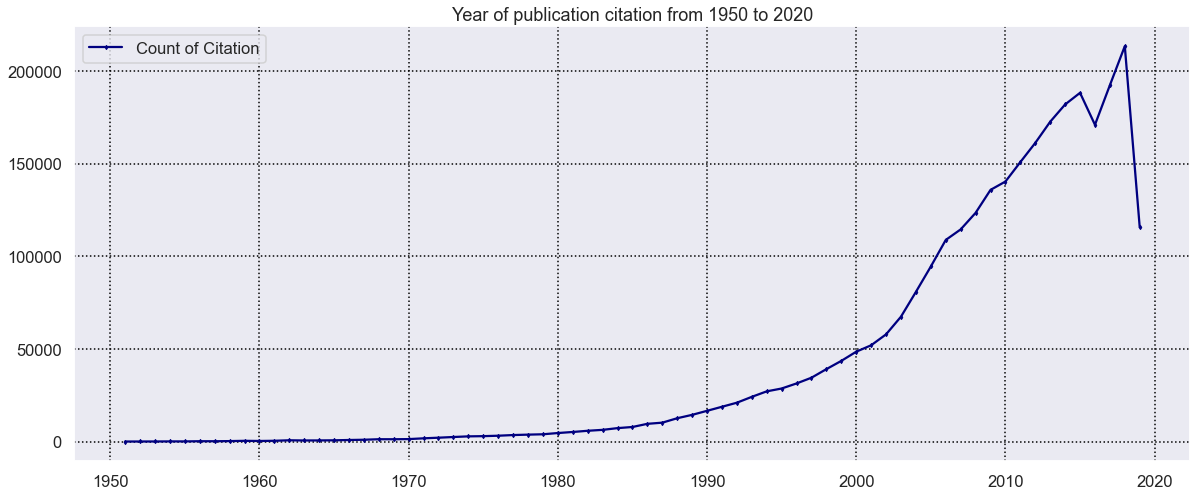

In [258]:
plot_series(n_citation_data, legend='Count of Citation', title='Year of citation groth from 1950 to 2020')

In [196]:
n_papers = df_total.groupby('year').count()['count']
n_papers = pd.DataFrame(n_papers).reset_index()
n_papers = n_papers[(n_papers['year'] > 1950) & (n_papers['year'] < 2020)]
n_papers = n_papers.set_index('year')

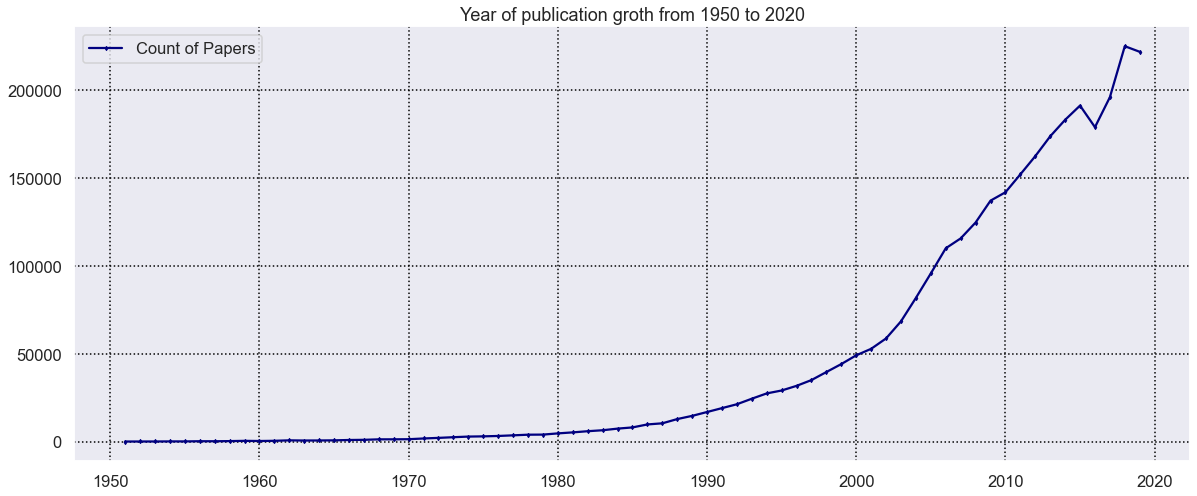

In [259]:
plot_series(n_papers, legend='Count of Papers', title='Year of publication groth from 1950 to 2020')

### year

In [60]:
print(df_total.year.max())
print(df_total.year.min())

2300.0
0.0


In [ ]:
df_total['page_end'].astype(float) - df_total['page_start'].astype(float)

## Bar Chart Race


In [366]:
import bar_chart_race as bcr

In [371]:
def get_bar_chart_race_dataframe(df: pd.DataFrame, index='year', column='auther_name', top=25):
    def _get_top_values():
        top_authors = df.groupby([column])[['title']].count()
        top_authors = top_authors.sort_values('title', ascending=False).iloc[:top, :].index
        return top_authors
    
    top_authors = _get_top_values()
    race = df[df[column].isin(top_authors)].groupby([column, index])['title'].count()
    race = race.reset_index()
    race['count'] = race['title']
    race = race.drop(columns=['title'], axis=1)
    race = race.pivot(index=index, columns=column, values='count').fillna(0)
    race.iloc[:, 0:-1] = race.iloc[:, 0:-1].cumsum()
    return race


In [372]:
race = get_bar_chart_race_dataframe(df)

In [383]:
bcr.bar_chart_race(df=race, n_bars=6, dpi=300)

# ========================

## col: Title

In [336]:
# todo: find most/least popular values (mapa)

In [177]:
df['title'].head(15)

id
1091     Preliminary Design of a Network Protocol Learn...
1388     Further Results on Independence in Direct-Prod...
1674     A methodology for the physically accurate visu...
1688     Comparison of GARCH, Neural Network and Suppor...
5411     COMPARING GNG3D AND QUADRIC ERROR METRICS METH...
5781                   Vectorial fast correlation attacks.
6522     Improved Secret Image Sharing Method By Encodi...
6762     A Self-Stabilizing Algorithm for Finding the C...
8373     Formal agent-oriented ubiquitous computing: a ...
8763     Fur Visualisation for Computer Game Engines an...
9415     Identifying Psychological Theme Words from Emo...
11068    Multisymplectic Spectral Methods for the Gross...
11796    The Role of the Board of Directors in IT Gover...
11895    Speech training systems using lateral shapes o...
12993          Software Evolution through Transformations.
Name: title, dtype: object

In [178]:
df['title'].tail(15)

id
1481989682    Semantic Navigation through Multiple Topic Ont...
1481989740        CIPS: coordinated intrusion prevention system
1481989822    Hybrid ARQ scheme with antenna permutation for...
1481989998    Soft handoff prioritizing algorithm for downli...
1481990707    Analytical performance evaluation of distribut...
1481991149                               Translating z to alloy
1481991844    New decoding strategy for underdetermined MIMO...
1481992253               Consistent evolution of OWL ontologies
1481992587    The ECOS green buildings project: data dramati...
1481992717    Existing plagiarism detection techniques: A sy...
1481992918    Weyl variations and local sufficiency of linea...
1481993126    A novel design of self-organizing approximator...
1481993566     Resource discovery protocol for mobile computing
1481994000                                 PIX, the latest NeWS
1481994496    iPRIDE: a parallel integrated circuit simulato...
Name: title, dtype: object

In [191]:
df.loc[[1481994000, 1481991149]]

,title,authors,venue,year,fos,references,n_citation,page_start,page_end,doc_type,publisher,volume,issue,doi,indexed_abstract
id,,,,,,,,,,,,,,,
1481994000,"PIX, the latest NeWS","[{'name': 'W. Leler', 'id': 2711287932}]",{'raw': 'IEEE Computer Society International C...,1989,"[{'name': 'Scheduling (computing)', 'w': Decim...",[1734912584],7.0,239.0,242.0,Conference,IEEE,NaN,NaN,10.1109/CMPCON.1989.301934,"{'IndexLength': 161, 'InvertedIndex': {'multip..."
1481991149,Translating z to alloy,"[{'name': 'Petra Malik', 'org': 'Victoria Univ...","{'raw': 'Abstract State Machines, Alloy, B and...",2010,"[{'name': 'Notation', 'w': Decimal('0.49072')}...","[1481939332, 1481955967, 1491364274, 151950347...",15.0,377.0,390.0,Conference,"Springer, Berlin, Heidelberg",NaN,NaN,10.1007/978-3-642-11811-1_28,"{'IndexLength': 137, 'InvertedIndex': {'extent..."


## col: authors

In [335]:
# todo: parse to separate dataframe
# todo: create title -> name

# 
# 

In [243]:
import json
import re

In [231]:
p = re.compile('(?<!\\\\)\'')
s = p.sub('\"', tmp)

In [290]:
tmp = df[['authors']].iloc[0, :][0][1:-1]
tmp

"{'name': 'Makoto Satoh', 'org': 'Shinshu University', 'id': 2312688602}, {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946}, {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587}, {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692}, {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191}, {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940}, {'name': 'Michio Shimizu', 'org': 'Nagano Prefectural College', 'id': 2134989941}, {'name': 'Masahiko Sugimoto', 'org': 'Takushoku University, Hokkaido Junior College', 'id': 2307479915}"

In [291]:
ss = '{' + tmp + '}'
ss

"{{'name': 'Makoto Satoh', 'org': 'Shinshu University', 'id': 2312688602}, {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946}, {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587}, {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692}, {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191}, {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940}, {'name': 'Michio Shimizu', 'org': 'Nagano Prefectural College', 'id': 2134989941}, {'name': 'Masahiko Sugimoto', 'org': 'Takushoku University, Hokkaido Junior College', 'id': 2307479915}}"

## col: venue

In [334]:
# todo: parse to separate dataframe

In [331]:
df[['venue']].iloc[0, 0]

"{'raw': 'International Conference on Human-Computer Interaction', 'id': 1127419992, 'type': 'C'}"

## col: year

In [ ]:
# todo: to int

In [333]:
df['year']

id
1091          2013
1388          2000
1674          2011
1688          2009
5411          2009
              ... 
1481992918    2015
1481993126    2003
1481993566    1996
1481994000    1989
1481994496    1988
Name: year, Length: 300001, dtype: object

## col: doc_type

In [498]:
df

,title,venue,year,keywords,fos,references,n_citation,page_start,page_end,lang,volume,abstract,auther_name,org_names
0,A solution to the problem of touching and brok...,"{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"['handwriting recognition', 'prototypes', 'ima...","['Intelligent character recognition', 'Pattern...","['53e99cf5b7602d97025ace63', '557e8a7a6fee0fe9...",17.0,602,605,en,NaN,NaN,Theo Pavlidis,[]
1,A solution to the problem of touching and brok...,"{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"['handwriting recognition', 'prototypes', 'ima...","['Intelligent character recognition', 'Pattern...","['53e99cf5b7602d97025ace63', '557e8a7a6fee0fe9...",17.0,602,605,en,NaN,NaN,Jairo Rocha,[]
2,360°,"{'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...",2009.0,"['global high technology', 'daily short-distan...",NaN,NaN,NaN,39,39,en,NaN,360° represents the concerns that are addresse...,Miguel Palma,['Miguel Palma Studio']
3,Firewalls.,{'raw': 'Encyclopedia of Cryptography and Secu...,2011.0,[],NaN,NaN,0.0,474,482,en,NaN,NaN,Ehab Al-Shaer,[]
4,Flubber,"{'_id': '5736ae3ad39c4f40a797600a', 'raw': 'SI...",1998.0,[],NaN,NaN,0.0,127,127,en,NaN,NaN,Vicki Dobbs Beck,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188745,Analysis and Classification of Biomedical Data...,"{'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}",2020.0,NaN,NaN,NaN,NaN,107.0,118,NaN,NaN,NaN,Sujata Panda,[]
1188746,Formulation and Optimization of Overcurrent Re...,"{'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}",2020.0,NaN,NaN,NaN,NaN,389.0,402,NaN,NaN,NaN,Gbenga Abidemi Olarinoye,[]
1188747,Formulation and Optimization of Overcurrent Re...,"{'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}",2020.0,NaN,NaN,NaN,NaN,389.0,402,NaN,NaN,NaN,Ahmed Tijani Salawudeen,[]
1188748,Formulation and Optimization of Overcurrent Re...,"{'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}",2020.0,NaN,NaN,NaN,NaN,389.0,402,NaN,NaN,NaN,Tajudeen Humble Sikiru,[]


In [497]:
df['venue']

0          {'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...
1          {'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...
2          {'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...
3          {'raw': 'Encyclopedia of Cryptography and Secu...
4          {'_id': '5736ae3ad39c4f40a797600a', 'raw': 'SI...
                                 ...                        
1188745       {'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}
1188746       {'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}
1188747       {'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}
1188748       {'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}
1188749       {'sid': 'conf/icta2', 't': 'C', 'raw': 'ICTA'}
Name: venue, Length: 1188750, dtype: object

In [496]:
temp = df.groupby('venue')[['venue']].count()
temp.columns = ['count']
temp = temp.reset_index()

fig = px.bar(temp, x='venue', y='count', color='venue')
fig.show()

KeyboardInterrupt: 

In [193]:
df['authors']['1091']

"[{'name': 'Makoto Satoh', 'org': 'Shinshu University', 'id': 2312688602}, {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946}, {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587}, {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692}, {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191}, {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940}, {'name': 'Michio Shimizu', 'org': 'Nagano Prefectural College', 'id': 2134989941}, {'name': 'Masahiko Sugimoto', 'org': 'Takushoku University, Hokkaido Junior College', 'id': 2307479915}]"

In [8]:
df['fos'][0]

"[{'name': 'Telecommunications network', 'w': Decimal('0.45139')}, {'name': 'Computer science', 'w': Decimal('0.45245')}, {'name': 'Mind map', 'w': Decimal('0.5347')}, {'name': 'Human–computer interaction', 'w': Decimal('0.47011')}, {'name': 'Multimedia', 'w': Decimal('0.46629')}, {'name': 'Empirical research', 'w': Decimal('0.49737')}, {'name': 'Comprehension', 'w': Decimal('0.47042')}, {'name': 'Communications protocol', 'w': Decimal('0.51907')}]"

In [9]:
df['doi'][0]

'10.1007/978-3-642-39476-8_19'

In [11]:
df['indexed_abstract'][0]

"{'IndexLength': 58, 'InvertedIndex': {'tool.': [42], 'study': [4], 'aim': [37], 'purpose': [1], 'scientific': [17], 'for': [11], 'aspects': [18], 'students': [14, 46], 'focus': [27], 'hands-on': [47], 'learning': [9, 41], 'experience': [48], 'our': [40], 'we': [26], 'network': [33, 56], 'The': [0], 'More': [24], 'high': [12], 'protocols.': [57], 'school': [13], 'and': [21], 'of': [2, 19, 32, 55], 'communication': [22], 'protocols': [34], 'gives': [45], 'on': [28], 'a': [8], 'studying': [15], 'specifically,': [25], 'this': [3], 'understand': [51], 'is': [5], 'develop': [7, 39], 'Our': [43], 'tool': [10, 44], 'the': [16, 29, 36, 52], 'help': [50], 'as': [35], 'principles': [31, 54], 'information': [20], 'networks.': [23], 'to': [6, 38, 49], 'basic': [30, 53]}}"

91.20069599768

In [7]:
df

,id,title,authors,venue,year,fos,references,n_citation,page_start,page_end,doc_type,publisher,volume,issue,doi,indexed_abstract
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",{'raw': 'International Conference on Human-Com...,2013,"[{'name': 'Telecommunications network', 'w': D...","[2005687710, 2018037215]",1.0,89,93,Conference,"Springer, Berlin, Heidelberg",NaN,NaN,10.1007/978-3-642-39476-8_19,"{'IndexLength': 58, 'InvertedIndex': {'tool.':..."
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]","{'raw': 'Ars Combinatoria', 'id': 73158690, 't...",2000,"[{'name': 'Graph', 'w': Decimal('0.0')}, {'nam...",NaN,1.0,NaN,NaN,Journal,NaN,56.0,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",{'raw': 'International Conference on Virtual R...,2011,"[{'name': 'Statue', 'w': Decimal('0.40216')}, ...","[1535888970, 1992876689, 1993710814, 203565334...",1.0,137,144,Conference,Eurographics Association,NaN,NaN,10.2312/VAST/VAST11/137-144,"{'IndexLength': 201, 'InvertedIndex': {'illust..."
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",{'raw': 'Pattern Recognition and Machine Intel...,2009,[{'name': 'Autoregressive–moving-average model...,"[1560724230, 1986968751, 2156909104]",6.0,597,602,Conference,"Springer, Berlin, Heidelberg",NaN,NaN,10.1007/978-3-642-11164-8_97,"{'IndexLength': 64, 'InvertedIndex': {'standar..."
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",{'raw': 'International Conference on Computer ...,2009,"[{'name': 'Computer vision', 'w': Decimal('0.4...",NaN,0.0,99,102,Conference,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300006,1481992918,Weyl variations and local sufficiency of linea...,"[{'name': 'Igor G. Vladimirov', 'id': 19827660...","{'raw': 'arXiv: Quantum Physics', 'id': 259519...",2015,"[{'name': 'Linear combination', 'w': Decimal('...","[1486692963, 2100144423, 2949265413]",1.0,NaN,NaN,Repository,NaN,NaN,NaN,NaN,"{'IndexLength': 178, 'InvertedIndex': {'cohere..."
300007,1481993126,A novel design of self-organizing approximator...,"[{'name': 'Dong-Won Kim', 'org': 'Dept. of Ele...","{'raw': 'Systems, Man and Cybernetics', 'id': ...",2003,"[{'name': 'Heuristic', 'w': Decimal('0.48582')...","[1639032689, 1966423772, 1984810512, 203147052...",3.0,4643.0,4648.0,Conference,IEEE,5.0,NaN,10.1109/ICSMC.2003.1245716,"{'IndexLength': 160, 'InvertedIndex': {'modeli..."
300008,1481993566,Resource discovery protocol for mobile computing,"[{'name': 'Charles E. Perkins', 'org': 'IBM T....","{'raw': 'Mobile Networks and Applications', 'i...",1996,"[{'name': 'Mobile technology', 'w': Decimal('0...","[1529205966, 1641167210, 1761598307, 177566302...",31.0,447.0,455.0,Journal,"Springer-Verlag New York, Inc.",1.0,4.0,10.1007/978-0-387-34980-0_22,"{'IndexLength': 72, 'InvertedIndex': {'tested'..."
300009,1481994000,"PIX, the latest NeWS","[{'name': 'W. Leler', 'id': 2711287932}]",{'raw': 'IEEE Computer Society International C...,1989,"[{'name': 'Scheduling (computing)', 'w': Decim...",[1734912584],7.0,239.0,242.0,Conference,IEEE,NaN,NaN,10.1109/CMPCON.1989.301934,"{'IndexLength': 161, 'InvertedIndex': {'multip..."


In [17]:
df

,id,title,authors,venue,year,fos,references,n_citation,page_start,page_end,doc_type,publisher,volume,issue,doi,indexed_abstract
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",{'raw': 'International Conference on Human-Com...,2013,"[{'name': 'Telecommunications network', 'w': D...","[2005687710, 2018037215]",1.0,89,93,Conference,"Springer, Berlin, Heidelberg",NaN,NaN,10.1007/978-3-642-39476-8_19,"{'IndexLength': 58, 'InvertedIndex': {'tool.':..."
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]","{'raw': 'Ars Combinatoria', 'id': 73158690, 't...",2000,"[{'name': 'Graph', 'w': Decimal('0.0')}, {'nam...",NaN,1.0,NaN,NaN,Journal,NaN,56.0,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",{'raw': 'International Conference on Virtual R...,2011,"[{'name': 'Statue', 'w': Decimal('0.40216')}, ...","[1535888970, 1992876689, 1993710814, 203565334...",1.0,137,144,Conference,Eurographics Association,NaN,NaN,10.2312/VAST/VAST11/137-144,"{'IndexLength': 201, 'InvertedIndex': {'illust..."
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",{'raw': 'Pattern Recognition and Machine Intel...,2009,[{'name': 'Autoregressive–moving-average model...,"[1560724230, 1986968751, 2156909104]",6.0,597,602,Conference,"Springer, Berlin, Heidelberg",NaN,NaN,10.1007/978-3-642-11164-8_97,"{'IndexLength': 64, 'InvertedIndex': {'standar..."
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",{'raw': 'International Conference on Computer ...,2009,"[{'name': 'Computer vision', 'w': Decimal('0.4...",NaN,0.0,99,102,Conference,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300006,1481992918,Weyl variations and local sufficiency of linea...,"[{'name': 'Igor G. Vladimirov', 'id': 19827660...","{'raw': 'arXiv: Quantum Physics', 'id': 259519...",2015,"[{'name': 'Linear combination', 'w': Decimal('...","[1486692963, 2100144423, 2949265413]",1.0,NaN,NaN,Repository,NaN,NaN,NaN,NaN,"{'IndexLength': 178, 'InvertedIndex': {'cohere..."
300007,1481993126,A novel design of self-organizing approximator...,"[{'name': 'Dong-Won Kim', 'org': 'Dept. of Ele...","{'raw': 'Systems, Man and Cybernetics', 'id': ...",2003,"[{'name': 'Heuristic', 'w': Decimal('0.48582')...","[1639032689, 1966423772, 1984810512, 203147052...",3.0,4643.0,4648.0,Conference,IEEE,5.0,NaN,10.1109/ICSMC.2003.1245716,"{'IndexLength': 160, 'InvertedIndex': {'modeli..."
300008,1481993566,Resource discovery protocol for mobile computing,"[{'name': 'Charles E. Perkins', 'org': 'IBM T....","{'raw': 'Mobile Networks and Applications', 'i...",1996,"[{'name': 'Mobile technology', 'w': Decimal('0...","[1529205966, 1641167210, 1761598307, 177566302...",31.0,447.0,455.0,Journal,"Springer-Verlag New York, Inc.",1.0,4.0,10.1007/978-0-387-34980-0_22,"{'IndexLength': 72, 'InvertedIndex': {'tested'..."
300009,1481994000,"PIX, the latest NeWS","[{'name': 'W. Leler', 'id': 2711287932}]",{'raw': 'IEEE Computer Society International C...,1989,"[{'name': 'Scheduling (computing)', 'w': Decim...",[1734912584],7.0,239.0,242.0,Conference,IEEE,NaN,NaN,10.1109/CMPCON.1989.301934,"{'IndexLength': 161, 'InvertedIndex': {'multip..."


In [16]:
df.shape[0]

300011

In [13]:
df['id'].nunique()

300010

In [28]:
df[['id']].groupby(['id'])['id'].count()

id
61467                                                                                 1
120715                                                                                1
156053                                                                                1
208239                                                                                1
443846                                                                                1
                                                                                     ..
ight                                                                                  2
m C}$ Actuator                                                                        1
m IP}^{2}{                                                                            1
m PROFIL}_{R}$ : Toward Preserving Privacy and Functionality in Geosocial Networks    1
m{I!R}^{3}                                                                            1
Name: id, Length: 300010, dty

In [41]:
df['id_new'] = df['id'].astype(str)
df['new_col2'] = df['id_new'].str.isdigit()


In [42]:
df[df['new_col2'] != True]

,id,title,authors,venue,year,fos,references,n_citation,page_start,page_end,doc_type,publisher,volume,issue,doi,indexed_abstract,id_new,new_col1,new_col2
19207,m IP}^{2}{,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,m IP}^{2}{,False,False
19208,m C}$ Actuator,"[{'name': 'Riccardo Caponetto', 'org': 'Dipt. ...",{'raw': 'IEEE Transactions on Instrumentation ...,2014,"[{'name': 'Data modeling', 'w': Decimal('0.455...","[1984717708, 2019425123, 2024991751, 204282619...",5,1347.0,1355,Journal,IEEE,63,5.0,10.1109/TIM.2014.2298172,"{'IndexLength': 139, 'InvertedIndex': {'been':...",NaN,m C}$ Actuator,False,False
21851,m{I!R}^{3},"[{'name': 'Klaus Gürlebeck', 'org': 'BAUHAUS U...",{'raw': 'International Conference on Computati...,2014,"[{'name': 'Linear combination', 'w': Decimal('...",NaN,1,189.0,203,Conference,"Springer, Cham",NaN,NaN,10.1007/978-3-319-09144-0_14,"{'IndexLength': 133, 'InvertedIndex': {'play':...",NaN,m{I!R}^{3},False,False
231197,ight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ight,False,False
231198,angle },NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angle },False,False
231199,ight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ight,False,False
231200,angle-LTL.,"[{'name': 'Aidan Harding', 'id': 2139993607}, ...",{'raw': 'TIME'},2003,"[{'name': 'Psychology', 'w': Decimal('0.32082'...",NaN,0,137.0,146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angle-LTL.,False,False
241036,ceil DEPTH(2 lceil log n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ceil DEPTH(2 lceil log n,False,False
241037,ceil -3).,"[{'name': 'Sudarshan K. Dhall', 'id': 29740243...",{'raw': 'International Conference on Parallel ...,1987,"[{'name': 'Binary logarithm', 'w': Decimal('0....",NaN,20,58.0,65,Conference,NaN,NaN,NaN,NaN,NaN,NaN,ceil -3).,False,False
241442,m PROFIL}_{R}$ : Toward Preserving Privacy and...,"[{'name': 'Bogdan Carbunar', 'org': 'Sch. of C...",{'raw': 'IEEE Transactions on Information Fore...,2014,"[{'name': 'Mobile computing', 'w': Decimal('0....","[1492124753, 1555820810, 1566461722, 160100179...",5,709.0,718,Journal,IEEE,9,4.0,10.1109/TIFS.2014.2307697,"{'IndexLength': 133, 'InvertedIndex': {'small'...",NaN,m PROFIL}_{R}$ : Toward Preserving Privacy and...,False,False


In [36]:
df[['id']].isdigit()

AttributeError: 'DataFrame' object has no attribute 'isdigit'

In [32]:
df.where(df.id.isdigit())

ValueError: Array conditional must be same shape as self